In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupKFold, GridSearchCV
from sklearn import linear_model 
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("data_vad.csv")
data = df[(df["Valence"].notna())&(df["Arousal"].notna())].drop(["filename"], axis = 1)

# Разделение данных

In [3]:
X1 = data[data["label"] == 1]["batch_id"].unique()
X2 = data[data["label"] == 2]["batch_id"].unique()
X3 = data[data["label"] == 3]["batch_id"].unique()

X1_train, X1_test = train_test_split(X1,train_size = 0.7, random_state = 42)
X2_train, X2_test = train_test_split(X2,train_size = 0.7, random_state = 42)
X3_train, X3_test = train_test_split(X3,train_size = 0.7, random_state = 42)
X_train = [*X1_train, *X2_train, *X3_train]
X_test = [*X1_test, *X2_test, *X3_test]
data_train = data[data["batch_id"].apply(lambda x: x in X_train)]
data_test = data[data["batch_id"].apply(lambda x: x in X_test)]

X = data_train.iloc[:,1:4]
X_test = data_test.iloc[:,1:4]
y_valence = data_train.iloc[:,4:5]
y_arousal = data_train.iloc[:,5:6]
y_valence_test = data_test.iloc[:,4:5]
y_arousal_test = data_test.iloc[:,5:6]

# Модели из коробки

In [4]:
def models_test(X, y, X_test, y_test):
    models = [DummyRegressor(), 
              linear_model.LinearRegression(), 
              linear_model.BayesianRidge(), 
              linear_model.ElasticNet(), 
              SVR(),  
              KNeighborsRegressor(),
              RandomForestRegressor(random_state = 42),
              GradientBoostingRegressor(random_state = 42),
              CatBoostRegressor(random_state = 42, verbose = False, iterations = 100, learning_rate = 0.1, depth = 3), 
              LGBMRegressor(random_state = 42, max_depth = 3), 
              XGBRegressor(random_state = 42, n_estimators = 100, max_depth = 3)]
    m = {"R2_train":{},"MAE_train":{},"MSE_train":{}, "R2_test":{},"MAE_test":{},"MSE_test":{}}
    for model in models:
        model.fit(X, y) 
        l = str(model)
        if '(' in l:
            m["R2_train"][l[:l.index('(')]] = r2_score(y, model.predict(X))
            m["MAE_train"][l[:l.index('(')]] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"][l[:l.index('(')]] = mean_squared_error(y, model.predict(X))
            m["R2_test"][l[:l.index('(')]] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"][l[:l.index('(')]] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"][l[:l.index('(')]] = mean_squared_error(y_test, model.predict(X_test))
        else:
            m["R2_train"]['CatBoost'] = r2_score(y, model.predict(X))
            m["MAE_train"]['CatBoost'] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"]['CatBoost'] = mean_squared_error(y, model.predict(X))
            m["R2_test"]['CatBoost'] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"]['CatBoost'] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"]['CatBoost'] = mean_squared_error(y_test, model.predict(X_test))
    return pd.DataFrame(m)

In [5]:
TestModelsArousal = models_test(X, y_arousal, X_test, y_arousal_test)
TestModelsValence = models_test(X, y_valence, X_test, y_valence_test)

# Модели после подбора параметров

In [6]:
def models_test_val(X, y, X_test, y_test):
    models = [DummyRegressor(), 
              linear_model.LinearRegression(), 
              linear_model.BayesianRidge(), 
              linear_model.ElasticNet(), 
              SVR(kernel = 'linear'),  
              KNeighborsRegressor(n_neighbors = 59),
              RandomForestRegressor(max_depth = 4, n_estimators = 100, random_state = 42),
              GradientBoostingRegressor(max_depth = 3, n_estimators = 100, random_state = 42),
              CatBoostRegressor(random_state = 42, verbose = False, iterations = 300, depth = 2), 
              LGBMRegressor(max_depth = 2, n_estimators = 100, random_state = 42), 
              XGBRegressor(n_estimators = 100, max_depth = 2, random_state = 42)]
    m = {"R2_train":{},"MAE_train":{},"MSE_train":{}, "R2_test":{},"MAE_test":{},"MSE_test":{}}
    for model in models:
        model.fit(X, y) 
        l = str(model)
        if '(' in l:
            m["R2_train"][l[:l.index('(')]] = r2_score(y, model.predict(X))
            m["MAE_train"][l[:l.index('(')]] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"][l[:l.index('(')]] = mean_squared_error(y, model.predict(X))
            m["R2_test"][l[:l.index('(')]] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"][l[:l.index('(')]] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"][l[:l.index('(')]] = mean_squared_error(y_test, model.predict(X_test))
        else:
            m["R2_train"]['CatBoost'] = r2_score(y, model.predict(X))
            m["MAE_train"]['CatBoost'] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"]['CatBoost'] = mean_squared_error(y, model.predict(X))
            m["R2_test"]['CatBoost'] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"]['CatBoost'] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"]['CatBoost'] = mean_squared_error(y_test, model.predict(X_test))
    return pd.DataFrame(m)

In [7]:
MTV = models_test_val(X, y_valence, X_test, y_valence_test)
MTV

,R2_train,MAE_train,MSE_train,R2_test,MAE_test,MSE_test
DummyRegressor,0.000000,0.279621,0.141360,-0.000724,0.322057,0.183098
LinearRegression,0.292631,0.245319,0.099994,0.031792,0.344960,0.177149
BayesianRidge,0.292628,0.245287,0.099994,0.032476,0.344764,0.177024
ElasticNet,0.280653,0.247715,0.101687,0.055822,0.337354,0.172752
SVR,0.282051,0.241916,0.101489,0.040378,0.336492,0.175578
KNeighborsRegressor,0.443555,0.218895,0.078659,0.095032,0.327900,0.165578
RandomForestRegressor,0.438478,0.218269,0.079377,0.195517,0.310267,0.147193
GradientBoostingRegressor,0.528358,0.198331,0.066671,0.158646,0.314584,0.153939
CatBoost,0.504263,0.203244,0.070078,0.148407,0.314132,0.155812
LGBMRegressor,0.444256,0.215525,0.078560,0.129350,0.321631,0.159299


In [8]:
def models_test_ar(X, y, X_test, y_test):
    models = [DummyRegressor(), 
              linear_model.LinearRegression(), 
              linear_model.BayesianRidge(), 
              linear_model.ElasticNet(), 
              SVR(kernel = 'linear'),  
              KNeighborsRegressor(n_neighbors = 102),
              RandomForestRegressor(max_depth = 2, n_estimators = 100, random_state = 42),
              GradientBoostingRegressor(max_depth = 1, n_estimators = 100, random_state = 42),
              CatBoostRegressor(random_state = 42, verbose = False, iterations = 100, depth = 1), 
              LGBMRegressor(max_depth = 1, n_estimators = 100, random_state = 42), 
              XGBRegressor(n_estimators = 100, max_depth = 1, random_state = 42)]
    m = {"R2_train":{},"MAE_train":{},"MSE_train":{}, "R2_test":{},"MAE_test":{},"MSE_test":{}}
    for model in models:
        model.fit(X, y) 
        l = str(model)
        if '(' in l:
            m["R2_train"][l[:l.index('(')]] = r2_score(y, model.predict(X))
            m["MAE_train"][l[:l.index('(')]] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"][l[:l.index('(')]] = mean_squared_error(y, model.predict(X))
            m["R2_test"][l[:l.index('(')]] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"][l[:l.index('(')]] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"][l[:l.index('(')]] = mean_squared_error(y_test, model.predict(X_test))
        else:
            m["R2_train"]['CatBoost'] = r2_score(y, model.predict(X))
            m["MAE_train"]['CatBoost'] = mean_absolute_error(y, model.predict(X))
            m["MSE_train"]['CatBoost'] = mean_squared_error(y, model.predict(X))
            m["R2_test"]['CatBoost'] = r2_score(y_test, model.predict(X_test))
            m["MAE_test"]['CatBoost'] = mean_absolute_error(y_test, model.predict(X_test))
            m["MSE_test"]['CatBoost'] = mean_squared_error(y_test, model.predict(X_test))
    return pd.DataFrame(m)

In [9]:
MTA = models_test_ar(X, y_arousal, X_test, y_arousal_test)
MTA

,R2_train,MAE_train,MSE_train,R2_test,MAE_test,MSE_test
DummyRegressor,0.000000,0.079065,0.011192,-0.034154,0.081231,0.008903
LinearRegression,0.109401,0.073219,0.009967,0.001630,0.078125,0.008595
BayesianRidge,0.109398,0.073229,0.009967,0.001609,0.078150,0.008595
ElasticNet,0.061871,0.076248,0.010499,-0.018700,0.080689,0.008770
SVR,0.092399,0.077732,0.010157,-0.059083,0.083974,0.009118
KNeighborsRegressor,0.232632,0.067111,0.008588,0.079092,0.072011,0.007928
RandomForestRegressor,0.183595,0.071186,0.009137,0.007178,0.077530,0.008547
GradientBoostingRegressor,0.221244,0.069011,0.008716,0.029842,0.074855,0.008352
CatBoost,0.232361,0.067896,0.008591,0.041813,0.073143,0.008249
LGBMRegressor,0.217718,0.069196,0.008755,0.031500,0.074775,0.008338


# Сравнение моделей до и после подбора параметров

### Сравнение для Valence

In [10]:
TestModelsValence['Модель'] = ["Без погружения и без подбора параметров"]*11
MTV['Модель'] = ["С подбором параметров, без погружения"]*11
df_Valence = TestModelsValence.append(MTV)

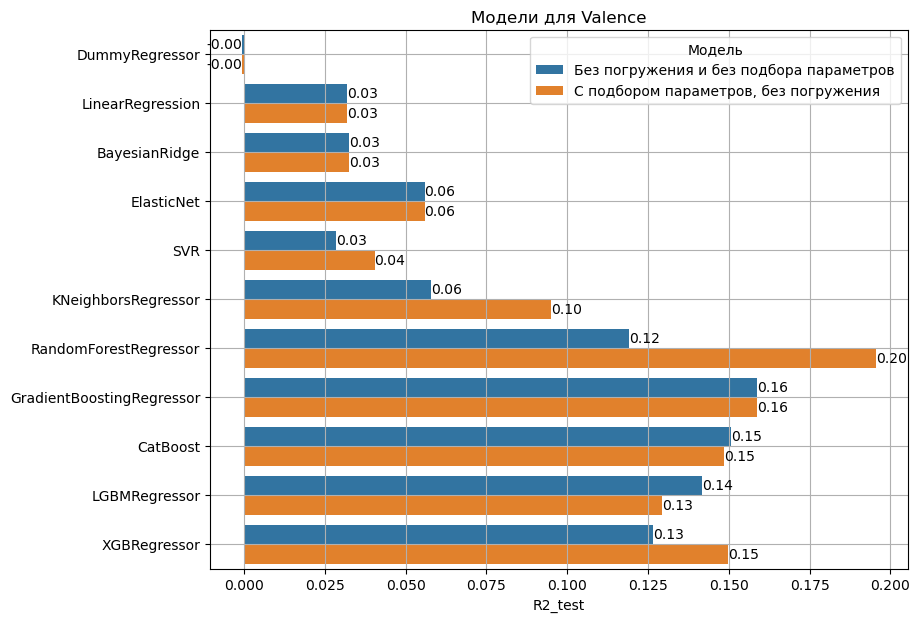

In [11]:
fig, ax = plt.subplots(figsize = (9, 7))
ax = sns.barplot(data = df_Valence, x = 'R2_test', y = df_Valence.index, hue = 'Модель')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.grid()
plt.title('Модели для Valence')
plt.show()

### Сравнение для Arousal

In [12]:
TestModelsArousal['Модель'] = ["Без погружения и без подбора параметров"]*11
MTA['Модель'] = ["С подбором параметров, без погружения"]*11
df_Arousal = TestModelsArousal.append(MTA)

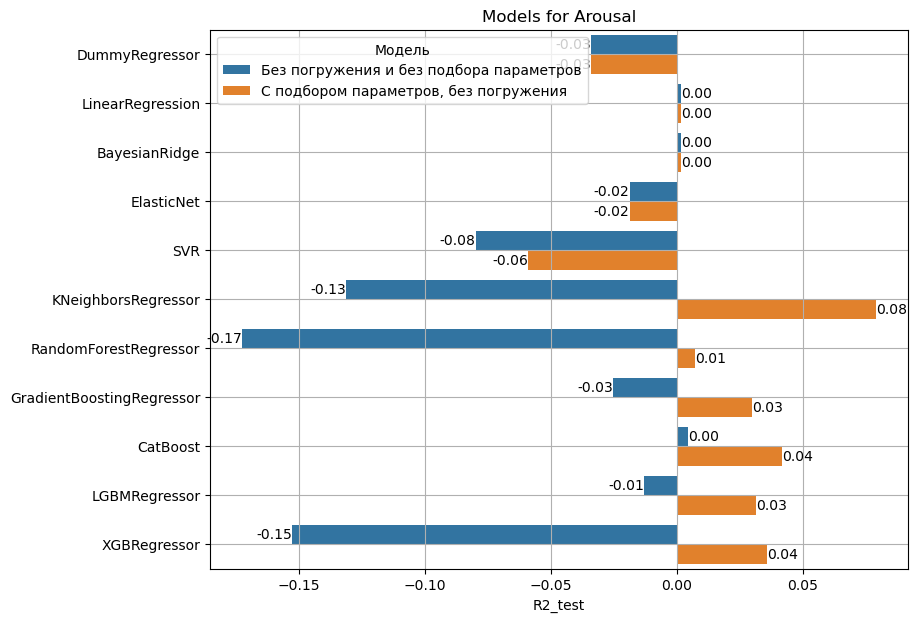

In [13]:
fig, ax = plt.subplots(figsize = (9, 7))
ax = sns.barplot(data = df_Arousal, x = 'R2_test', y = df_Arousal.index, hue = 'Модель')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.grid()
plt.title('Models for Arousal')
plt.show()

### Сохранение результатов работы моделей

In [14]:
with pd.ExcelWriter('Model_results.xlsx') as writer:
    df_Arousal.to_excel(writer, sheet_name='Resalts_for_Arousal')
    df_Valence.to_excel(writer, sheet_name='Resalts_for_Valence')